# Finding Filled Rectangles in Binary Images

In [1]:
%matplotlib inline

import numpy as np
import numba
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fn = '../assets/img/maximal-rect/{}.jpg'

In [2]:
# random images

def circle(n, c=None, r=None):
    if r is None:
        r = .45 * n
    if c is None:
        c = .5 * n * np.ones(2)
    x = (np.arange(n) - c[0])**2
    y = (np.arange(n) - c[1])**2
    return np.where(x[:, None] + y[None, :] < r * r)


def get_image(n, r=.52, r_hole=.05, n_holes=20):
    arr = np.zeros((n, n), dtype=np.int32)
    arr[circle(n, r=r * n)] = 1
    r = r_hole * n
    for _ in range(n_holes):
        c = np.random.randint(int(r), n - int(r), 2)
        arr[circle(n, c=c, r=r)] = 0
    return arr

In [23]:
# plots

def show(img, grid=True, style={}, ax=None):
    n = img.shape[0]
    if ax is None:
        fig, ax = plt.subplots()
    rect_style = dict(edgecolor='none', facecolor=(.6,) * 3)
    rect_style.update(style)
    for x, y in zip(*np.where(img)):
        ax.add_patch(Rectangle((y, x), 1, 1, **rect_style))
    
    if grid:
        for i in range(n):
            ax.axhline(i, color='k', linewidth=.5)
            ax.axvline(i, color='k', linewidth=.5)
    
    ax.set_xlim((0, n))
    ax.set_ylim((0, n))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1)
    return ax


def draw_rect(rect, ax, color=(0, 0, 1)):
    top, left, bottom, right = rect
    fc = color + (.3,)
    ax.add_patch(
        Rectangle((left, top), right - left + 1, bottom - top + 1, facecolor=fc, linewidth=4, edgecolor=color)
    )


def show_mat(arr, rect=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(arr, cmap=plt.cm.Blues)
    if rect:
        top, left, bottom, right = rect
        ax.add_patch(
            Rectangle(
                (left - .5, top - .5), right - left + 1, bottom - top + 1,
                facecolor=(1., 0, 0, .3), edgecolor='r'
            )
        ) 
    return ax

In [4]:
@numba.jit
def get_heights(arr):
    res = np.zeros(arr.size, dtype=np.int32)
    res[0] = arr[0]
    i = 1
    for a in arr[1:]:
        if a == 0:
            res[i] = 0
        else:
            res[i] = res[i - 1] + 1
        i += 1
    return res


@numba.jitclass([
    ('_stack', numba.int32[:, :]),
    ('size', numba.int32),
])
class Stack:
    def __init__(self, size):
        self._stack = np.empty((size, 2), dtype=np.int32)
        self.size = 0
        
    def push(self, pos, height):
        self._stack[self.size, 0] = pos
        self._stack[self.size, 1] = height
        self.size += 1
        
    def pop(self):
        self.size -= 1
        v = self._stack[self.size]
        return v[0], v[1]
    
    def peek_height(self):
        return self._stack[self.size - 1][1]


@numba.jit
def get_hist_maximal_rect(heights):
    """find the maximal rectangle contained in a histogram."""
    def push_required(h, stack):
        if h == 0:
            return False
        if stack.size == 0:
            return True
        return h > stack.peek_height()
    
    stack = Stack(heights.size)
    max_area = -1
    lo, hi = -1, -1
    for i in range(heights.size + 1):
        # terminate with a zero height to clear the stack
        h = heights[i] if i < heights.size else 0
        if push_required(h, stack):
            stack.push(i, h)
        elif h < stack.peek_height():
            while stack.size and h < stack.peek_height():
                left, height = stack.pop()
                area = height * (i - left)
                if area > max_area:
                    max_area = area
                    lo, hi = left, i - 1
            if push_required(h, stack):
                stack.push(left, h)

    return np.array([lo, hi, max_area])


def get_maximal_rect(img):
    """find the maximum area rectangle that contains only ones."""
    row_heights = np.apply_along_axis(get_heights, 0, img)
    left, right, area = np.apply_along_axis(get_hist_maximal_rect, 1, row_heights).T
    bottom = np.argmax(area)
    h = area[bottom] // (right[bottom] - left[bottom] + 1) - 1
    return bottom - h, left[bottom], bottom, right[bottom]

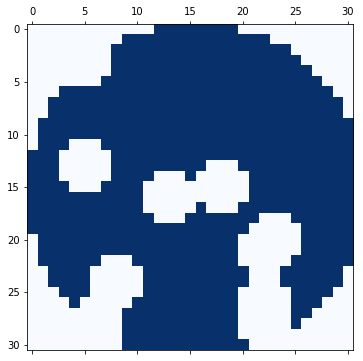

In [77]:
n = 31
# img = get_image(n, r_hole=.08, n_holes=10)
rect = get_maximal_rect(img)
show_mat(img)

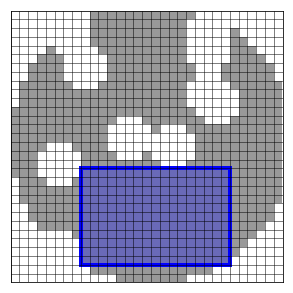

In [78]:
fig, ax = plt.subplots(figsize=(5, 5))
show(img, ax=ax)
draw_rect(rect, ax)
fig.savefig(fn.format('basic-example'))

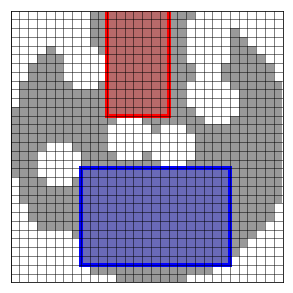

In [79]:
fig, ax = plt.subplots(figsize=(5, 5))
show(img, ax=ax)
draw_rect(rect, ax=ax)
draw_rect((19, 11, 30, 17), ax=ax, color=(1,0,0))
fig.savefig(fn.format('rect-extendable'))

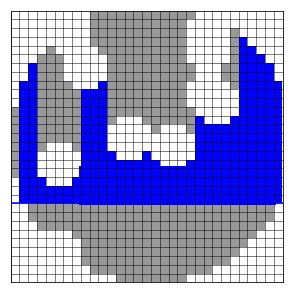

In [80]:
bottom = int(.3 * n)
heights = np.apply_along_axis(get_heights, 0, img[::-1])[::-1][bottom]
left, right = get_hist_maximal_rect(heights)[:2]
h = min(heights[left:right + 1])

histogram = np.zeros_like(img)
for i in range(n):
    histogram[bottom:bottom + heights[i], i] = 1
# ax = show(img)
fig, ax = plt.subplots(figsize=(5, 5))

show(img, grid=False, ax=ax)
show(histogram, grid=True, style=dict(facecolor='b'), ax=ax)
ax.axhline(bottom, color='b')
draw_rect((bottom, left, bottom + h - 1, right), ax)
fig.savefig(fn.format('histogram'))

In [81]:
class Stack:
    def __init__(self, size):
        self._stack = np.empty((size, 2), dtype=np.int32)
        self.size = 0
        
    def push(self, pos, height):
        self._stack[self.size, 0] = pos
        self._stack[self.size, 1] = height
        self.size += 1
        
    def pop(self):
        self.size -= 1
        v = self._stack[self.size]
        return v[0], v[1]
    
    def peek_height(self):
        return self._stack[self.size - 1][1]


def get_hist_maximal_rect_debug(heights):
    def push_required(h, stack):
        if h == 0:
            return False
        if stack.size == 0:
            return True
        return h > stack.peek_height()

    stack = Stack(heights.size)
    max_area = -1
    lo, hi = -1, -1
    rects = []
    for i in range(heights.size + 1):
        h = heights[i] if i < heights.size else 0
        if push_required(h, stack):
            stack.push(i, h)
        elif h < stack.peek_height():
            while stack.size and h < stack.peek_height():
                left, height = stack.pop()
                area = height * (i - left)
                rects.append((left, i - 1, height))
                if area > max_area:
                    max_area = area
                    lo, hi = left, i - 1
            if push_required(h, stack):
                stack.push(left, h)

    return np.array([lo, hi, max_area // (hi - lo + 1)]), rects

best, rects = get_hist_maximal_rect_debug(heights)

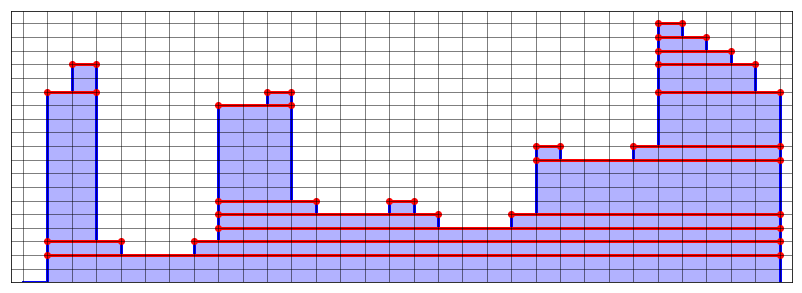

In [82]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(np.arange(n), heights, width=1., align='edge', facecolor=(0, 0, 1, .3), edgecolor='none')
h = np.concatenate([[0], np.c_[heights, heights].ravel(), [0]])
x = np.c_[np.arange(n + 1), np.arange(n + 1)].ravel()
ax.plot(x, h, 'b-', linewidth=3)

for left, right, height in rects:
    ax.plot([left, right + 1], [height, height], 'ro-', linewidth=3)

ax.set_xticks([])
ax.set_yticks([])
style = dict(color='k', linewidth=.5)
for i in range(n + 1):
    ax.axvline(i, **style)
for i in range(heights.max() + 1):
    ax.axhline(i, **style)
ax.set_xlim((-.5, n + .5))
fig.savefig(fn.format('hist-rects'))

CPU times: user 108 ms, sys: 804 µs, total: 109 ms
Wall time: 109 ms


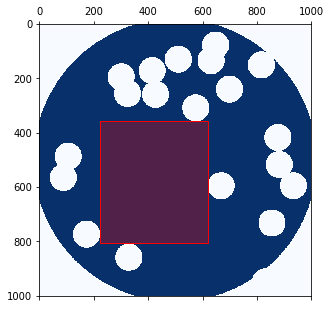

In [84]:
n = 1000
arr = get_image(n=n)
%time rect = get_maximal_rect(arr)

top, left, bottom, right = rect
assert np.all(arr[top:bottom + 1, left:right+1])

fig, ax = plt.subplots(figsize=(5, 5))
show_mat(arr, rect, ax=ax)
fig.savefig(fn.format('large-example'))

In [27]:
np.array([1,2,3]).dtype

dtype('int64')